In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
os.chdir('..')

In [2]:
df = pd.read_csv('./data/data.csv')
df['redox_potential'] = df['redox_potential'].astype(float)

<Axes: >

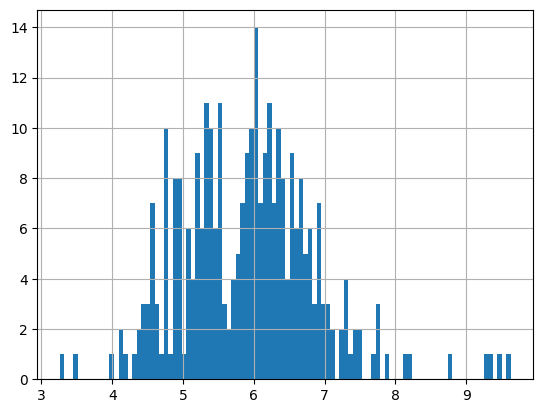

In [3]:
df.redox_potential.hist(bins=100)

In [4]:
from src.data_loader import load_graph_data, GraphDataModule

In [25]:
# data loader
data_module = GraphDataModule(csv_path='./data/data.csv', test_size=0.3, batch_size=16)

In [26]:
len(data_module.test_data), len(data_module.train_data), len(data_module.val_data)

(45, 211, 46)

In [27]:
next(iter(data_module.train_dataloader()))

[Graph(num_nodes=113, num_edges=311,
       ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
       edata_schemes={}),
 tensor([5.1200, 5.9900, 6.1000, 6.3900, 4.9100, 6.1200, 6.5800, 6.1900, 5.3600,
         5.9800, 5.4200, 7.3000, 5.7000, 4.8700, 5.7700, 4.6600])]

In [34]:
from src.model import lightiningGNN
# Initialize the model
model = lightiningGNN(in_dim=74, gcn_hidden_dim=256, fcn_hidden_dim=256, out_dim=1,
                          n_gcn_layers=2, n_fcn_layers=1, learning_rate=1e-3)
print(f'model: \n{model}')

model: 
lightiningGNN(
  (model): GNN(
    (conv_layers): ModuleList(
      (0): GraphConv(in=74, out=256, normalization=both, activation=None)
      (1): GraphConv(in=256, out=256, normalization=both, activation=None)
    )
    (classify_layers): ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (criterion): MSELoss()
)


In [40]:
import pytorch_lightning as pl

trainer = pl.Trainer(max_epochs=5, deterministic=True, enable_progress_bar=True, accelerator='cpu')
trainer.fit(model, data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gbemidebe/miniconda3/envs/knnMoleSearch/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name      | Type    | Params
--------------------------------------
0 | model     | GNN     | 151 K 
1 | criterion | MSELoss | 0     
--------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.604     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/gbemidebe/miniconda3/envs/knnMoleSearch/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Above works only for cpu for now!

# 2. New Sampler

In [ ]:
import pandas as pd
import numpy as np
import torch
import dgl
from src.utils import graph_dataset

data = pd.read_csv('./data/data.csv')

dataset = graph_dataset(
                        np.asarray(data.smiles, dtype="str"), 
                        np.asarray(data.redox_potential, dtype="float"))

In [ ]:
from sklearn.model_selection import train_test_split
length = len(dataset)
all_idx = np.arange(length)

train_idx, test_idx = train_test_split(all_idx, test_size=0.2, random_state=42)

In [ ]:
train_loader = dgl.dataloading.DataLoader(graph = dataset,
                                          indices=train_idx,
                                          device=torch.device('cpu'),
                                          graph_sampler = dgl.dataloading.Sampler(),
                                          batch_size = 16)

In [ ]:
next(iter(train_loader))

In [ ]:
def collate(samples):
    graphs, labels = map(list, zip(*samples))
    graphs = dgl.batch(graphs)
    return graphs, torch.tensor(labels).unsqueeze(-1)

In [ ]:
graph, label = collate(dataset)

In [ ]:
graph

In [ ]:
try:
    print(graph.ndata['h'].shape)
except:
    len(graph)

In [ ]:
label[:5]

In [ ]:
graph.ndata['h'].shape[1]

In [ ]:
graph.ndata['h'].shape

In [ ]:
# graph.ndata["label"] = label.squeeze()
from dgl.dataloading import GraphDataLoader
dataloader = GraphDataLoader(
    dataset,
    batch_size=5, device='cpu',
    drop_last=False,
    shuffle=True)

In [ ]:
next(iter(dataloader))

In [ ]:
# Define the LightningDataModule for the GNN model
from pytorch_lightning import LightningDataModule
from dgl.dataloading import GraphDataLoader
class GraphDataModule(LightningDataModule):
    def __init__(self, csv_path, test_size=0.2, batch_size=16):
        super().__init__()
        graph_dataset, self.train_idx, self.test_idx, \
                        self.val_idx = load_graph_data(seed=42, test_size=test_size, csv_path=csv_path)
        graphs, labels = collate(graph_dataset) # collate the dataset
        self.graphLoader = GraphDataLoader(dataset=, batch_size=batch_size, shuffle=True)
        self.batch_size = batch_size # batch size
        self.in_feats = graphs.ndata['h'].shape[1] # input features shape
        self.sampler = Sampler()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

    def train_dataloader(self):
        return DataLoader(graph = self.graph_data, indices = self.train_idx,
                          batch_size=self.batch_size, graph_sampler = self.sampler,
                          device=self.device, shuffle=False)
    
    def val_dataloader(self):
        return DataLoader(graph = self.graph_data, indices = self.val_idx,
                          batch_size=self.batch_size, graph_sampler = self.sampler, 
                          device=self.device, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(graph = self.graph_data, indices = self.test_idx, 
                          batch_size=self.batch_size, graph_sampler = self.sampler, 
                          device=self.device, shuffle=False)

In [ ]:
dgl_data = GraphDataModule(csv_path='./data/data.csv', test_size=0.2, batch_size=16)

In [ ]:
next(iter(dgl_data.train_dataloader()))

In [ ]:
g1 = dgl.graph((torch.tensor([0, 1, 2]), torch.tensor([1, 2, 3])))
# 3 nodes, 4 edges
g2 = dgl.graph((torch.tensor([0, 0, 0, 1]), torch.tensor([0, 1, 2, 0])))
bg = dgl.batch([g1, g2])
bg

In [ ]:
g1

In [ ]:
g2